In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
cd ~/workspace/theislab/mubind/docs/notebooks/concatenation

/mnt/c/Users/IgnacioIbarra/Dropbox/workspace/theislab/mubind/docs/notebooks/concatenation


In [5]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [6]:
import glob
import pickle
import os
models_list = glob.glob('../../../mubind-pipeline/output/snakemake/*/*/*/models/*.h5')
print(len(models_list))
models = []
for model_path in models_list:
    # if not 'N_200' in model_path or 'K_1' in model_path or not 'B_64' in model_path or not 'L_0.01' in model_path:
    #     continue
#     if not 'EGR' in model_path:
#         continue
    pkl_path = model_path.replace('.h5', '.pkl')
    print(pkl_path)

    if not os.path.exists(model_path) or not os.path.exists(pkl_path):
        continue
    model = pickle.load(open(pkl_path, 'rb'))
    # model.load_state_dict(torch.load(model_path))
    models.append(model)
    # break
    continue
    # model = pickle.load(open(pkl_path, 'rb'))

# results
results_paths = glob.glob('../../../mubind-pipeline/output/snakemake/*/*/*/metrics.tsv')
print(len(models_list))
metrics = []
for results_path in results_paths:
#     if not "ALX" in results_path:
#         continue
    # print(results_path)
    # if not 'N_200' in model_path or 'K_1' in model_path or not 'B_64' in model_path or not 'L_0.01' in model_path:
    #     continue
    df = pd.read_csv(results_path, index_col=0)
    metrics.append(df)

if len(metrics) != 0:
    metrics = pd.concat(metrics)

0
0


In [7]:
metrics

[]

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [23]:
# binding_modes = mb.tl.binding_modes("../../../annotations/mubind-pipeline-output/snakemake_test/*/*/fit_model/models/*",
binding_modes = mb.tl.binding_modes("../../../../mubind-pipeline/output/snakemake/*/*/fit_model/models/*",
                                    pos_weight_thr=0, device=device, stop_at=100) # pos_weight_thr=0.1, )

# of models 0
Using device: cuda:0


In [10]:
# binding_modes

In [11]:
sub_bm = mb.models.BindingModesSimple()
del sub_bm.conv_mono[0:2]
sub_bm.conv_mono.extend([binding_modes.conv_mono[i] for i in [1, 2, 3]])

ModuleList(
  (0-2): 3 x Conv2d(1, 1, kernel_size=(4, 15), stride=(1, 1), bias=False)
)

True

True
10
order None
0 out of 3...


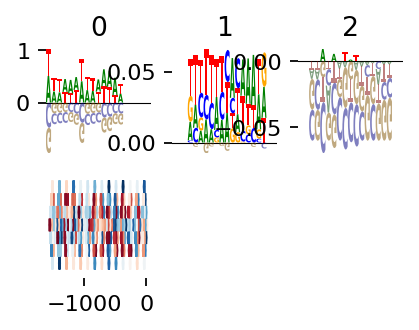

In [17]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 10
rcParams['figure.dpi'] = 160
n_cols = 10
n_rows = 10
mb.pl.logo(sub_bm, n_cols=n_cols,
           n_rows=n_rows, # len(binding_modes), n_rows=10,
           title=True, xticks=False, yticks=False)

3

In [22]:
monos = [m.weight.cpu().detach().numpy().squeeze().copy() for m in sub_bm.conv_mono[:3]]
%time res = mb.tl.calculate_distances(monos, best=True, full=True)
# %load_ext line_profiler
# %lprun -f mb.tl.distances_dataframe mb.tl.calculate_distances(monos, best=True, full=True)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<function flip at 0x7fa754202310>) found for signature:
 
 >>> flip(array(float32, 2d, A), list(int64)<iv=[1]>)
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'np_flip': File: numba/np/arrayobj.py: Line 6145.
    With argument(s): '(array(float32, 2d, A), list(int64)<iv=None>)':
   Rejected as the implementation raised a specific error:
     TypingError: too many positional arguments
  raised from /home/ilibarra/.conda/envs/mubind/lib/python3.8/site-packages/numba/core/typing/templates.py:784

During: resolving callee type: Function(<function flip at 0x7fa754202310>)
During: typing of call at /mnt/c/Users/IgnacioIbarra/Dropbox/workspace/theislab/mubind/mubind/tl/aggregation.py (158)


File "../../../mubind/tl/aggregation.py", line 158:
def submatrix(m, start, length, flip, filter_neg_weights=True):
    <source elided>
    if flip:
        sub_m = np.flip(sub_m, [1])
        ^


In [ ]:
res = res[res['a'] >= res['b']]
res['id'] = res['a'].astype(str) + '_' + res['b'].astype(str)
res = res.sort_values('distance').drop_duplicates('id')

In [ ]:
arr = res.pivot('a', 'b', 'distance')
arr = pd.DataFrame(np.tril(arr) + np.tril(arr).T)
dist_mat = arr.to_numpy()

/tmp/ipykernel_3704/3382856964.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  arr = res.pivot('a', 'b', 'distance')


In [ ]:
import scanpy as sc
import numpy as np
import scanpy as sc
import anndata

n = arr.shape[0]
k = 3
adata = sc.AnnData(shape=(n, 1))

dist_mat = np.random.rand(n, n)
# make it symmetrical
dist_mat= np.tril(dist_mat) + np.tril(dist_mat, -1).T
np.fill_diagonal(dist_mat, 0)

adata.obsp["distances"], adata.obsp["connectivities"] = sc.neighbors._compute_connectivities_umap(
    *sc.neighbors._get_indices_distances_from_dense_matrix(dist_mat, k),
    dist_mat.shape[0],
    k,
)
adata.uns["neighbors"] = {"connectivities_key": "connectivities", "distances_key": "distances", "params": {"method": None}}

sc.tl.umap(adata)
sc.tl.leiden(adata)

/home/rio/miniconda3/envs/mubind/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


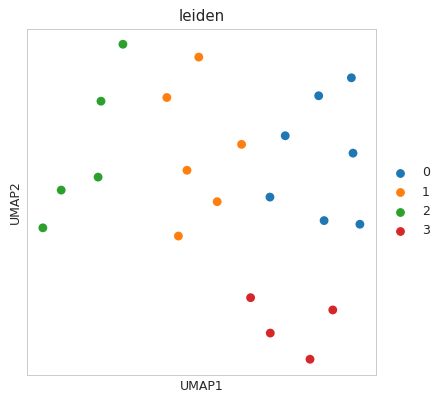

In [ ]:
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 90

sc.pl.umap(adata, color='leiden', s=200)

ModuleList(
  (0): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
  (1): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
  (2): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
  (3): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
  (4): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
)

3
(10, 10)


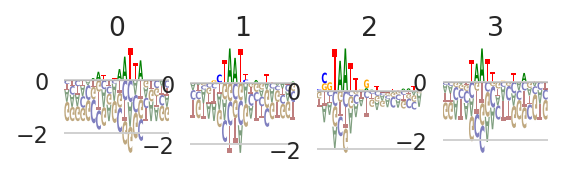

2
(10, 10)


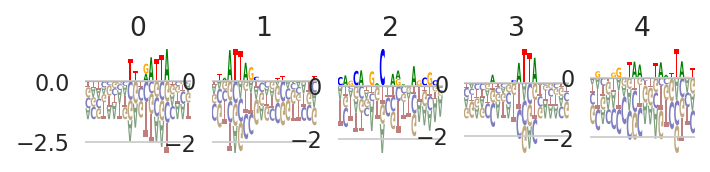

0
(10, 10)


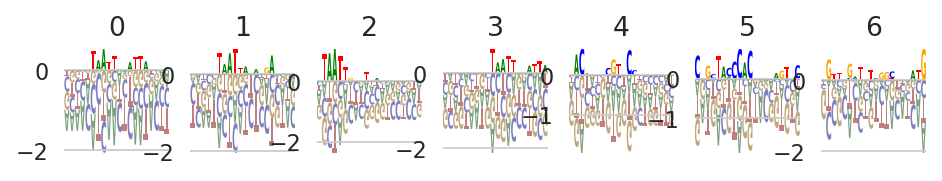

1
(10, 10)


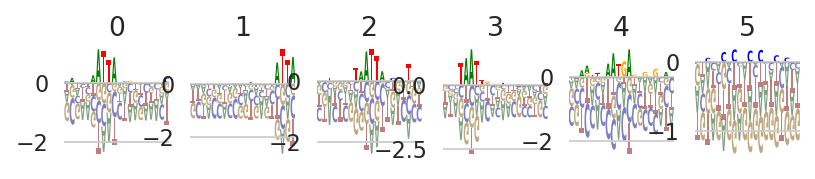

In [ ]:
for k in set(adata.obs['leiden']):
    print(k)
    sel = set(adata[adata.obs['leiden'] == k,:].obs_names.astype(int))
    sub_bm = mb.models.BindingModesSimple()
    del sub_bm.conv_mono[0:2]
    sub_bm.conv_mono.extend([binding_modes.conv_mono[i] for i in sel])

    from matplotlib import rcParams
    rcParams['figure.figsize'] = 10, 10
    rcParams['figure.dpi'] = 160
    n_cols = 10
    n_rows = 10
    mb.pl.conv_mono(sub_bm, n_cols=n_cols,
                    n_rows=n_rows, # len(binding_modes), n_rows=10,
                    title=True, xticks=False, yticks=False)

In [ ]:
### visualize using default anndata/scanpy associated functions

(2745148, 12)

In [ ]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)
reduced_groups = mb.tl.reduce_filters(sub_bm, thr_group=0.03)

iteration 1
# grouping (1, 13)
[1 0 9 7 11 11 11 4.209306716918945 3.083080291748047 0
 0.058655868877064095 '1_0' False]
option 2
(4, 20) (4, 20) (4, 22) (4, 22) 0 -2
# of remaining groups 2
iteration 2
# grouping (0, 0)
done. No more groups to generate


### Using the generated models, reload the data, set them up as priors, and relearn actitivies

In [ ]:
import os

n_sample = 100
df = []

input_paths = glob.glob('../../annotations/mubind-pipeline-output/snakemake/*/*/*/*.tsv.gz')
print(input_paths)
batch = 0
batch_by_name = {}
for p in input_paths:
    if not "ALX" in p:
        continue
    # print(p)
    df2 = pd.read_csv(p, sep='\t', index_col=0) # .head(100)
    assert 'batch' in df2
    # print(df2.columns)
    # df2 = df2.sample(100000)
    n_rounds = len(df2.columns) - 2
    df2.columns =  list(range(n_rounds)) + ['batch', 'is_count_data']
    df2['batch'] = batch
    batch_by_name[batch] = os.path.basename(p)
    df2['n_rounds'] = n_rounds
    # df2 = mb.pp.sample_rounds(df2, n_rounds, n_sample_per_round)
    print(df2.shape)
    df2 = df2.sample(n_sample)
    print(p, df2.shape, n_rounds)
    batch += 1
    df.append(df2)
    # assert False
    # break

df = pd.concat(df)
df = df[[c for c in df.columns if not c in ['batch', 'is_count_data', 'n_rounds']] + ['batch', 'is_count_data', 'n_rounds']]

['../../annotations/mubind-pipeline-output/snakemake/ALX1/SELEX/prepare/ALX1-ZeroCycle_ES0_TAAAGC20NCG_0-TAAAGC20NCG_1000.tsv.gz', '../../annotations/mubind-pipeline-output/snakemake/ALX1/SELEX/prepare/ALX1-ZeroCycle_ES0_TAAAGC20NCG_0-TAAAGC20NCG_10000.tsv.gz', '../../annotations/mubind-pipeline-output/snakemake/ALX1/SELEX/prepare/ALX1-ZeroCycle_TAAAGC20NCG_0_0-TAAAGC20NCG_1000.tsv.gz', '../../annotations/mubind-pipeline-output/snakemake/ALX1/SELEX/prepare/ALX1-ZeroCycle_TAAAGC20NCG_0_0-TAAAGC20NCG_10000.tsv.gz', '../../annotations/mubind-pipeline-output/snakemake/ALX1/SELEX/prepare/ALX1-ZeroCycle_TACCAA40NTTA_0_0-TACCAA40NTTA_1000.tsv.gz', '../../annotations/mubind-pipeline-output/snakemake/ALX1/SELEX/prepare/ALX1-ZeroCycle_TACCAA40NTTA_0_0-TACCAA40NTTA_10000.tsv.gz', '../../annotations/mubind-pipeline-output/snakemake/ALX1/SELEX/prepare/ALX1-ZeroCycle_TCCTTG40NGGT_0_0-TCCTTG40NGGT_1000.tsv.gz', '../../annotations/mubind-pipeline-output/snakemake/ALX1/SELEX/prepare/ALX1-ZeroCycle_TCCT

In [ ]:
df['batch'].value_counts()

0     100
1     100
26    100
25    100
24    100
23    100
22    100
21    100
20    100
19    100
18    100
17    100
16    100
15    100
14    100
13    100
12    100
11    100
10    100
9     100
8     100
7     100
6     100
5     100
4     100
3     100
2     100
27    100
Name: batch, dtype: int64

In [ ]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df['n_rounds'], labels=list(df.columns[:-3]), store_rev=False)
train = tdata.DataLoader(dataset=dataset,
                         # batch_size=256,
                         batch_size=512,
                         shuffle=False)


In [ ]:
# reduced_groups = reduced_groups[:2]
len(reduced_groups)

2

In [ ]:
n_kernels = len(reduced_groups)

In [ ]:

criterion = mb.tl.PoissonLoss()

n_rounds = train.dataset.n_rounds
n_batches = train.dataset.n_batches
enr_series = train.dataset.enr_series

model = mb.models.Multibind(
    datatype="selex",
    kernels=[0] + [m.shape[-1] for m in reduced_groups],
    n_rounds=n_rounds,
    init_random=False,
    n_batches=n_batches,
    enr_series=enr_series,
    dinuc_mode='full',
).to(device)

for i, mono_best in enumerate(reduced_groups):
    # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
    # print(model.binding_modes.conv_mono[i + 1].weight.device)
    new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
    model.binding_modes.conv_mono[i + 1].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
    # print(model.binding_modes.conv_mono[i + 1].weight.device)
# move the model a final time to the GPU
model = model.to(device)



True
3
(84, 84)
(76, 76)


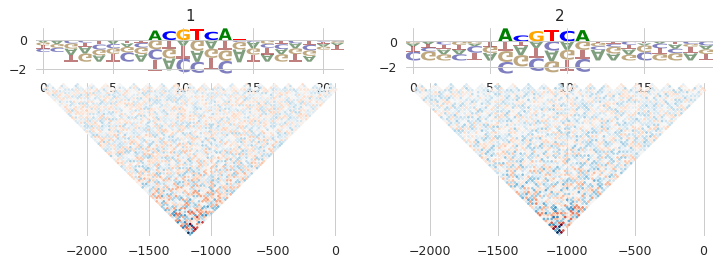

In [ ]:
rcParams['figure.figsize'] = 15, 3
rcParams['figure.dpi'] = 90
mb.pl.conv(model, n_cols=len(reduced_groups), title=False, xticks=False, rowspan_dinuc=3, rowspan_mono=1)


True
6
(76, 76)
(76, 76)
(76, 76)
(76, 76)
(76, 76)


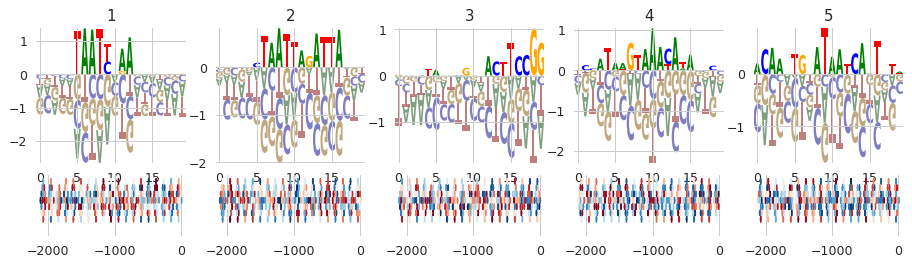

In [ ]:
criterion = mb.tl.PoissonLoss()

n_rounds = train.dataset.n_rounds
n_batches = train.dataset.n_batches
enr_series = train.dataset.enr_series

model = mb.models.Multibind(
    datatype="selex",
    kernels=[0] + [m.shape[-1] for m in reduced_groups],
    n_rounds=n_rounds,
    init_random=False,
    n_batches=n_batches,
    enr_series=enr_series,
    dinuc_mode='local',
).to(device)

for i, mono_best in enumerate(reduced_groups):
    # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
    # print(model.binding_modes.conv_mono[i + 1].weight.device)
    new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
    model.binding_modes.conv_mono[i + 1].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
    # print(model.binding_modes.conv_mono[i + 1].weight.device)
# move the model a final time to the GPU
model = model.to(device)
mb.pl.conv(model, n_cols=len(reduced_groups), title=False, xticks=True, rowspan_mono=2, rowspan_dinuc=1)


In [ ]:
def unfreeze(model, feat_lab=None, position=None):
    # block mononucleotide but free dinucleotide and activities to calibrate themselves during training
    verbose = 1
    for ki in range(n_kernels + 1):
        mask_pos = (ki == position if position is not None else True)
        mask_mono = (feat_lab == 'mono') and mask_pos
        mask_dinuc = (feat_lab == 'dinuc') and mask_pos
        if verbose != 0:
            print("setting grad status of kernel (mono, dinuc) at %i to (%i, %i)" % (ki, mask_mono, mask_dinuc))
        model.binding_modes.update_grad_mono(ki, mask_mono)
        model.binding_modes.update_grad_di(ki, mask_dinuc)

### Here we recalibrate first the log_activities and etas, by freezing mono/dinuc

In [ ]:
unfreeze(model, None)
# upfreeze ns binding
model.binding_modes.update_grad_mono(0, True)
model.binding_modes.update_grad_di(0, True)

setting grad status of kernel (mono, dinuc) at 0 to (0, 0)
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
setting grad status of kernel (mono, dinuc) at 3 to (0, 0)
setting grad status of kernel (mono, dinuc) at 4 to (0, 0)
setting grad status of kernel (mono, dinuc) at 5 to (0, 0)


In [ ]:
# assert False
next_optimiser = topti.Adam(model.parameters(), lr=0.025, weight_decay=0.001)
next_early_stopping = 25
log_each = 25
dirichlet_regularization = 0
exp_max = 40
verbose = 1
num_epochs = 1000

mb.tl.optimize_simple(
    model,
    train,
    device,
    next_optimiser,
    criterion,
    num_epochs=num_epochs,
    early_stopping=next_early_stopping,
    log_each=log_each,
    dirichlet_regularization=dirichlet_regularization,
    exp_max=exp_max,
    verbose=verbose,
)


optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 1000 
early_stopping: 25
lr= 0.025, weight_decay= 0.001, dir weight= 0
Epoch: 26, Loss: 2.379718,  best epoch: 24,  secs per epoch: 0.198 s,  secs epoch*1k trials: 0.247s
Epoch: 51, Loss: 1.844152,  best epoch: 49,  secs per epoch: 0.194 s,  secs epoch*1k trials: 0.242s
Epoch: 76, Loss: 1.521261,  best epoch: 74,  secs per epoch: 0.189 s,  secs epoch*1k trials: 0.236s
Epoch: 101, Loss: 1.325521,  best epoch: 99,  secs per epoch: 0.186 s,  secs epoch*1k trials: 0.233s
Epoch: 126, Loss: 1.182230,  best epoch: 124,  secs per epoch: 0.184 s,  secs epoch*1k trials: 0.230s
Epoch: 151, Loss: 1.084495,  best epoch: 149,  secs per epoch: 0.183 s,  secs epoch*1k trials: 0.229s
Epoch: 176, Loss: 1.019059,  best epoch: 174,  secs per epoch: 0.183 s,  secs epoch*1k trials: 0.228s
Epoch: 201, Loss: 0.970740,  best epoch: 199,  secs per epoch: 0.182 s,  secs epoch*1k trials: 0.228s
Epoch: 226, Loss: 0.932575,  best epoch: 224,  secs per epoch: 0.182

True
6
(76, 76)
(76, 76)
(76, 76)
(76, 76)
(76, 76)


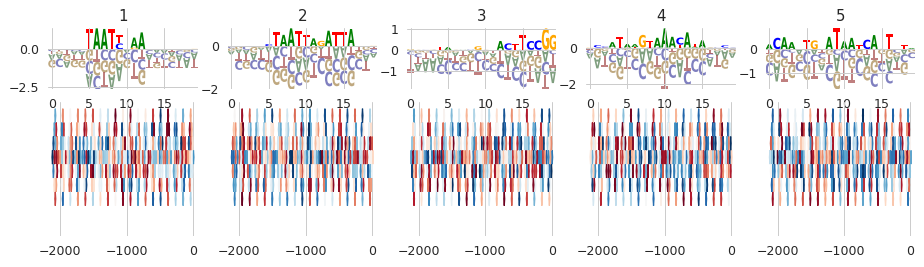

In [ ]:
# plot kernels (they should look the same as before
mb.pl.conv(model, n_cols=len(reduced_groups), title=False, xticks=True, rowspan_mono=1, rowspan_dinuc=2)

<AxesSubplot: >

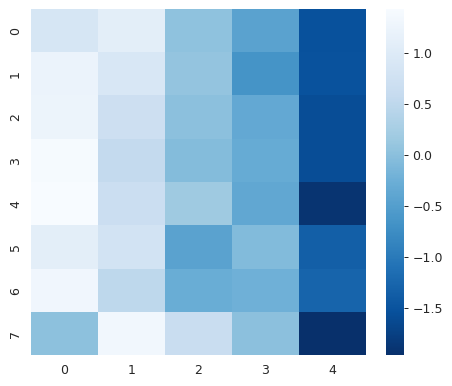

In [ ]:
import seaborn as sns
rcParams['figure.figsize'] = 6, 5
sns.heatmap(model.get_log_etas().detach().cpu().numpy(), cmap='Blues_r')

In [ ]:
rcParams['figure.figsize'] = 20, 20
# mb.pl.activities(model, n_cols=10, n_rows=8)

In [ ]:
pd.DataFrame(mb.tl.scores(model, train, by='batch'))

,0,1,2,3,4,5,6,7
r2_counts,0.796023,0.469658,0.606977,0.966360,0.174564,0.076331,0.081200,0.295395
r2_foldchange,0.698530,0.434169,0.352127,0.623494,0.259545,0.099255,0.165215,0.371147
r2_enr,0.876454,0.672220,0.761931,0.966031,0.312888,0.112815,0.157659,0.557782
r2_fc,0.723470,0.498137,0.381767,0.639589,0.344785,0.162602,0.220450,0.440197
pearson_foldchange,0.850570,0.705788,0.617873,0.799743,0.587184,0.403239,0.469521,0.663473


In [ ]:
for ki in range(1, len(reduced_groups) + 1):
    print('\nnext kernel to refine')
    unfreeze(model, 'mono', position=ki) # mono at 1
    # assert False
    next_optimiser = topti.Adam(model.parameters(), lr=0.025, weight_decay=0.001)
    next_early_stopping = 100
    log_each = 25
    dirichlet_regularization = 0
    exp_max = 40
    verbose = 1
    num_epochs = 250

    mb.tl.optimize_simple(
        model,
        train,
        device,
        next_optimiser,
        criterion,
        num_epochs=num_epochs,
        early_stopping=next_early_stopping,
        log_each=log_each,
        dirichlet_regularization=dirichlet_regularization,
        exp_max=exp_max,
        verbose=verbose,
    )



next kernel to refine
setting grad status of kernel (mono, dinuc) at 0 to (0, 0)
setting grad status of kernel (mono, dinuc) at 1 to (1, 0)
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
setting grad status of kernel (mono, dinuc) at 3 to (0, 0)
setting grad status of kernel (mono, dinuc) at 4 to (0, 0)
setting grad status of kernel (mono, dinuc) at 5 to (0, 0)
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 250 
early_stopping: 100
lr= 0.025, weight_decay= 0.001, dir weight= 0
Epoch: 26, Loss: 0.422277,  best epoch: 19,  secs per epoch: 0.185 s,  secs epoch*1k trials: 0.231s
Epoch: 51, Loss: 0.422189,  best epoch: 28,  secs per epoch: 0.182 s,  secs epoch*1k trials: 0.228s
Epoch: 76, Loss: 0.422185,  best epoch: 28,  secs per epoch: 0.181 s,  secs epoch*1k trials: 0.227s
Epoch: 101, Loss: 0.422183,  best epoch: 28,  secs per epoch: 0.181 s,  secs epoch*1k trials: 0.226s
Epoch: 126, Loss: 0.422183,  best epoch: 28,  secs per epoch: 0.181 s,  secs epoch*1k trials: 0.226

True
6
(76, 76)
(76, 76)
(76, 76)
(76, 76)
(76, 76)


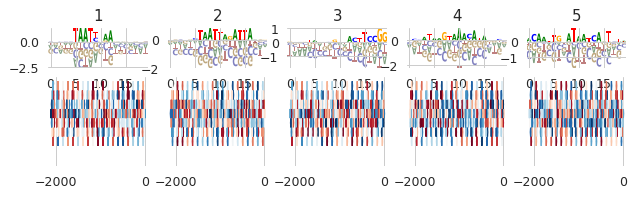

In [ ]:
# plot kernels (they should look the same as before
rcParams['figure.figsize'] = 10, 2
mb.pl.conv(model, n_cols=len(reduced_groups), title=False, xticks=True, rowspan_mono=1, rowspan_dinuc=2)

## Exploratory: Compare the old/new r2 values generates by the individual vs reduced models

0
1
2
3
4
5
6
7


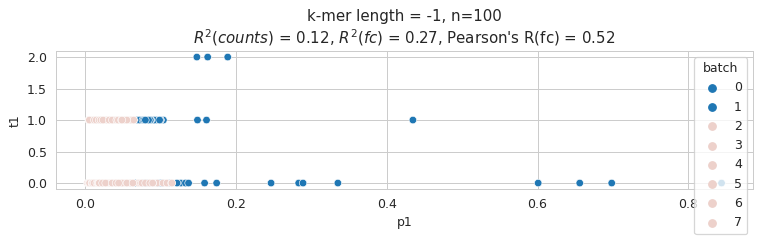

In [ ]:
scores_by_batch = mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', show=False, by='batch')
df_batch = pd.DataFrame(scores_by_batch).T

In [ ]:
df_batch['filename'] = df_batch.index.astype(int).map(batch_by_name)
metrics['filename'] = list(metrics['counts_path'].apply(os.path.basename))

In [ ]:
merged = df_batch.merge(metrics, on='filename', suffixes=('_independent', '_merged'))

xlab, ylab = 'r2_counts_independent', 'r2_counts_merged'
x, y = merged[xlab], merged[ylab]

import scipy
scipy.stats.pearsonr(x, y)

PearsonRResult(statistic=-1.0, pvalue=1.0)

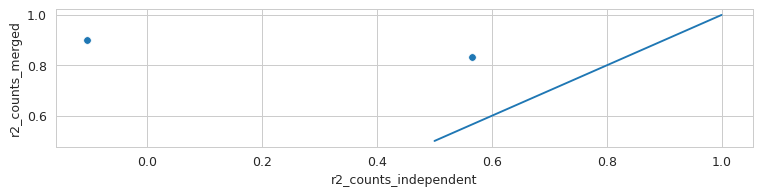

In [ ]:
sns.scatterplot(data=merged, x=xlab, y=ylab)
plt.plot([.5, 1], [.5, 1])
